# UGround vs Qwen2-VL Evaluation on Click-100k

This notebook compares the performance of:
- **osunlp/UGround-V1-2B**
- **Qwen/Qwen2-VL-2B**

on GUI element coordinate recognition using the first 100 samples from the `mlfoundations/Click-100k` dataset.


In [1]:
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from openai import OpenAI
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict, List
import base64
from io import BytesIO


## 1. Setup Model API Clients (vLLM)

**Before running this notebook, start vLLM OpenAI-compatible servers (one per model):**

```bash
cd /root/CSE291A_ECUA3
source /root/miniconda3/etc/profile.d/conda.sh
conda activate ecua

# Terminal 1: UGround
python -m vllm.entrypoints.openai.api_server \
  --model osunlp/UGround-V1-2B \
  --trust-remote-code \
  --port 8000 \
  --host 0.0.0.0 \
  --gpu-memory-utilization 0.40 \
  --max-num-seqs 4 &

# Terminal 2: Qwen2-VL
python -m vllm.entrypoints.openai.api_server \
  --model Qwen/Qwen2-VL-2B-Instruct \
  --trust-remote-code \
  --port 8001 \
  --host 0.0.0.0 \
  --gpu-memory-utilization 0.40 \
  --max-num-seqs 4 &
```

Notes:
- Both servers speak the OpenAI API; this notebook calls them via `OpenAI` clients.
- Ports: `8000` for UGround, `8001` for Qwen2-VL.
- Uses cached weights from `/workspace/cache/huggingface` if available.
- If a server is already running, keep the same port/model combo and skip the launch command.

If you prefer the older paths (Transformers hosting or SGLang), adjust the next cell accordingly, but the default below assumes vLLM endpoints.


In [10]:
# Model configurations for vLLM OpenAI endpoints
MODEL_CONFIGS = {
    "uground-2b": {
        "model_id": "osunlp/UGround-V1-2B",
        "endpoint": "http://localhost:8000/v1",
    },
    "qwen2-vl-2b": {
        "model_id": "Qwen/Qwen2-VL-2B-Instruct",
        "endpoint": "http://localhost:8001/v1",
    },
}

print("Using vLLM OpenAI-compatible hosting (one server per model)")

# Initialize OpenAI clients for each model
clients = {}

print("Setting up API clients...")
print("Note: Make sure vLLM servers are running on the specified ports")
print("-" * 60)

for key, cfg in MODEL_CONFIGS.items():
    endpoint = cfg["endpoint"]
    try:
        clients[key] = OpenAI(
            base_url=endpoint,
            api_key="EMPTY"  # Not required for local vLLM servers
        )
        print(f"✓ {key} client ready at {endpoint}")
    except Exception as e:
        print(f"✗ Failed to set up {key} client: {e}")
        print(f"  Make sure the server is running on {endpoint}")


# Verify connection to each vLLM model server by making a simple request

def verify_vllm_server_connection(client, model_name):
    # Send a lightweight request (list models) -- supported by vLLM OpenAI API
    models = client.models.list()
    if hasattr(models, "data") and len(models.data) > 0:
        print(f"✓ Connection verified for {model_name}: available models {[m.id for m in models.data]}")
    else:
        raise RuntimeError(f"Connection to {model_name} succeeded but returned no models.")

print("\nVerifying API server connections...")
for key, client in clients.items():
    verify_vllm_server_connection(client, key)


print("\nAll API clients configured!")
print("\nNote: Models are hosted via vLLM servers; they are NOT loaded inside this notebook.")


Using vLLM OpenAI-compatible hosting (one server per model)
Setting up API clients...
Note: Make sure vLLM servers are running on the specified ports
------------------------------------------------------------
✓ uground-2b client ready at http://localhost:8000/v1
✓ qwen2-vl-2b client ready at http://localhost:8001/v1

Verifying API server connections...
✓ Connection verified for uground-2b: available models ['osunlp/UGround-V1-2B']
✓ Connection verified for qwen2-vl-2b: available models ['Qwen/Qwen2-VL-2B-Instruct']

All API clients configured!

Note: Models are hosted via vLLM servers; they are NOT loaded inside this notebook.


## 2. Helper Functions


In [11]:
def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 data URL."""
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"


def build_uground_messages(description: str, image_url: str):
    """
    Build chat messages in OpenAI format for vision-language models.
    """
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": image_url}
                },
                {
                    "type": "text",
                    "text": f"""Find the coordinates of the element described below. Return ONLY the coordinates in the format (x, y) with no additional text.

Description: {description}

Coordinates:"""
                },
            ],
        },
    ]


def call_model_raw(
    image: Image.Image,
    query: str,
    client: OpenAI,
    model_name: str,
) -> Tuple[str, int, int]:
    """
    Send one screenshot + grounding query to SGLang API, return:
    (raw_text_response, orig_width, orig_height).
    """
    orig_w, orig_h = image.size
    
    # Convert image to base64
    image_url = image_to_base64(image)
    
    # Build messages in OpenAI format
    messages = build_uground_messages(query, image_url)
    
    try:
        # Call SGLang API (OpenAI-compatible)
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            max_tokens=128,
            temperature=0.0,
        )
        
        reply = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API call error: {e}")
        reply = ""
    
    return reply, orig_w, orig_h


def parse_xy_from_string(text: str) -> Tuple[int, int]:
    """
    Extract (x, y) coordinates from a string.
    Handles various formats:
    - (x, y) - two coordinates
    - (x1, y1, x2, y2) - four coordinates (bbox), computes center
    - Multiple coordinate pairs - takes the first valid one
    """
    if not text or not text.strip():
        raise ValueError(f"Empty text provided")
    
    # Clean the text - remove extra whitespace and newlines
    text = text.strip()
    
    # Try to find coordinate patterns: (num, num) or (num, num, num, num)
    # Pattern 1: (x, y) - two coordinates
    pattern_two = re.findall(r"\(\s*(\d+)\s*,\s*(\d+)\s*\)", text)
    # Pattern 2: (x1, y1, x2, y2) - four coordinates (bbox)
    pattern_four = re.findall(r"\(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\)", text)
    
    # First try to find a simple (x, y) pair in [0, 1000) range
    if pattern_two:
        for match in pattern_two:
            x, y = int(match[0]), int(match[1])
            if 0 <= x < 1000 and 0 <= y < 1000:
                return x, y
    
    # If we found a bbox format (x1, y1, x2, y2), compute center
    if pattern_four:
        for match in pattern_four:
            x1, y1, x2, y2 = int(match[0]), int(match[1]), int(match[2]), int(match[3])
            # Compute center
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            # If coordinates are in [0, 1000) range, use center
            if 0 <= center_x < 1000 and 0 <= center_y < 1000:
                return center_x, center_y
            # If coordinates are in pixel space (> 1000), use first two if in range
            elif 0 <= x1 < 1000 and 0 <= y1 < 1000:
                return x1, y1
    
    # Fallback: try to extract just the first two numbers
    numbers = re.findall(r'\d+', text)
    if len(numbers) >= 2:
        x, y = int(numbers[0]), int(numbers[1])
        # Clamp to [0, 1000) range
        x = max(0, min(999, x))
        y = max(0, min(999, y))
        return x, y
    
    raise ValueError(f"Could not parse valid coordinates from: {text[:200]!r}")


def scale_to_pixels(x_1000: int, y_1000: int, width: int, height: int) -> Tuple[int, int]:
    """
    Map model coordinates in [0,1000) to pixel coordinates of the original image.
    """
    x_px = int(x_1000 / 1000 * width)
    y_px = int(y_1000 / 1000 * height)
    x_px = max(0, min(width - 1, x_px))
    y_px = max(0, min(height - 1, y_px))
    return x_px, y_px


def predict_coordinates(
    image: Image.Image,
    query: str,
    model_key: str,
) -> Tuple[int, int, str]:
    """
    Predict coordinates using the specified model via vLLM OpenAI endpoint.
    Returns: (x_px, y_px, raw_response)
    """
    cfg = MODEL_CONFIGS[model_key]
    client = clients[model_key]
    model_name = cfg["model_id"]
    
    reply, orig_w, orig_h = call_model_raw(image, query, client, model_name)
    
    # If reply is empty, return center as fallback
    if not reply or reply.strip() == "":
        return orig_w // 2, orig_h // 2, reply
    
    try:
        x_1000, y_1000 = parse_xy_from_string(reply)
        x_px, y_px = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)
        return x_px, y_px, reply
    except ValueError as e:
        # If parsing fails, return center of image as fallback
        # Only print warning if reply is not empty (to avoid spam)
        if reply.strip():
            print(f"Warning: Failed to parse coordinates from {model_key}: {e}, reply: {reply[:50]}")
        return orig_w // 2, orig_h // 2, reply


def euclidean_distance(x1: int, y1: int, x2: int, y2: int) -> float:
    """Calculate Euclidean distance between two points."""
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def bbox_to_center(bbox: List[int]) -> Tuple[int, int]:
    """
    Convert bounding box [x1, y1, x2, y2] to center coordinates (x, y).
    """
    if len(bbox) != 4:
        raise ValueError(f"Bbox must have 4 elements, got {len(bbox)}")
    x1, y1, x2, y2 = bbox
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    return center_x, center_y


## 3. Load Click-100k Dataset


In [12]:
print("Loading Click-100k dataset...")
dataset = load_dataset("mlfoundations/Click-100k", split="train")
print(f"Total samples in dataset: {len(dataset)}")

# Take first 100 samples
eval_dataset = dataset.select(range(min(1000, len(dataset))))
print(f"Evaluating on {len(eval_dataset)} samples")
print(f"\nDataset features: {eval_dataset.features}")
print(f"\nSample keys: {eval_dataset[0].keys()}")


Loading Click-100k dataset...


Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/58 [00:00<?, ?it/s]

Total samples in dataset: 101314
Evaluating on 1000 samples

Dataset features: {'image_path': Value('string'), 'images': List(Image(mode=None, decode=True)), 'easyr1_prompt': Value('string'), 'bbox': List(Value('int64')), 'image_width': Value('int64'), 'image_height': Value('int64'), 'normalized_bbox': List(Value('float64'))}

Sample keys: dict_keys(['image_path', 'images', 'easyr1_prompt', 'bbox', 'image_width', 'image_height', 'normalized_bbox'])


## 4. Run Evaluation


In [13]:
# Initialize results storage
results = {
    "uground-2b": [],
    "qwen2-vl-2b": [],
    "ui-tars-1.5-7b": []
}

# Process each sample
print("Running evaluation...")
for idx in tqdm(range(len(eval_dataset)), desc="Processing samples"):
    sample = eval_dataset[idx]
    
    # Extract image from dataset - images is a list, take the first one
    images_list = sample.get("images")
    if images_list is None or len(images_list) == 0:
        print(f"Skipping sample {idx}: no images found")
        continue
    
    # Get the first image from the list
    image = images_list[0]
    if not isinstance(image, Image.Image):
        # If it's not already a PIL Image, try to convert
        if hasattr(image, "convert"):
            image = image.convert("RGB")
        else:
            print(f"Skipping sample {idx}: cannot process image format")
            continue
    
    # Extract query
    query = sample.get("easyr1_prompt")
    if query is None:
        print(f"Skipping sample {idx}: missing query")
        continue
    
    # Extract bbox and convert to center coordinates
    bbox = sample.get("bbox")
    if bbox is None or len(bbox) != 4:
        print(f"Skipping sample {idx}: invalid bbox {bbox}")
        continue
    
    try:
        gt_x, gt_y = bbox_to_center(bbox)
    except Exception as e:
        print(f"Skipping sample {idx}: error converting bbox: {e}")
        continue
    
    # Evaluate both models
    for model_key in MODEL_CONFIGS.keys():
        try:
            pred_x, pred_y, raw_response = predict_coordinates(image, query, model_key)
            distance = euclidean_distance(pred_x, pred_y, gt_x, gt_y)
            
            results[model_key].append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": pred_x,
                "pred_y": pred_y,
                "distance": distance,
                "raw_response": raw_response,
            })
        except Exception as e:
            print(f"Error processing sample {idx} with {model_key}: {e}")
            results[model_key].append({
                "sample_idx": idx,
                "query": query,
                "bbox": bbox,
                "gt_x": gt_x,
                "gt_y": gt_y,
                "pred_x": None,
                "pred_y": None,
                "distance": float('inf'),
                "raw_response": str(e),
                "error": True,
            })

print("\nEvaluation complete!")


Running evaluation...


Processing samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing samples: 100%|██████████| 1000/1000 [24:47<00:00,  1.49s/it]


Evaluation complete!


## Switch to UI-TARS-1.5-7B (run after finishing 2B evaluations)

1) Stop the 2B servers (and any nginx on 8000/8001):
```bash
pkill -f "vllm.entrypoints.openai.api_server" || true
pkill -f nginx || true
```

2) Start UI-TARS-1.5-7B with higher memory utilization (0.9):
```bash
cd /workspace/CSE291A_ECUA3
source /root/miniconda3/etc/profile.d/conda.sh
conda activate ecua
export LD_LIBRARY_PATH="$CONDA_PREFIX/lib/python3.11/site-packages/torch/lib:$CONDA_PREFIX/lib:$LD_LIBRARY_PATH"
export MKL_THREADING_LAYER=GNU
export OMP_NUM_THREADS=4
python -m vllm.entrypoints.openai.api_server \
  --model ByteDance-Seed/UI-TARS-7B-DPO \
  --trust-remote-code \
  --port 8000 \
  --host 0.0.0.0 \
  --gpu-memory-utilization 0.9 \
  --max-num-seqs 1
```

Then run the TARS evaluation cell below (assumes the server is listening on port 8000)

In [25]:
# UI-TARS-1.5-7B evaluation (run only after starting the server on port 8000)
TARS_MODEL_ID = "ByteDance-Seed/UI-TARS-7B-DPO"
TARS_ENDPOINT = "http://localhost:8000/v1"

try:
    tars_client = OpenAI(base_url=TARS_ENDPOINT, api_key="EMPTY")
except Exception as e:
    raise RuntimeError(f"Failed to init TARS client: {e}")

tars_results = []
print("Running UI-TARS-1.5-7B evaluation...")
for idx in tqdm(range(len(eval_dataset)), desc="Processing samples (ui-tars-7b)"):
    sample = eval_dataset[idx]

    images_list = sample.get("images")
    if images_list is None or len(images_list) == 0:
        print(f"Skipping sample {idx}: no images found")
        continue

    image = images_list[0]
    if not isinstance(image, Image.Image):
        if hasattr(image, "convert"):
            image = image.convert("RGB")
        else:
            print(f"Skipping sample {idx}: cannot process image format")
            continue

    query = sample.get("easyr1_prompt")
    if query is None:
        print(f"Skipping sample {idx}: missing query")
        continue

    bbox = sample.get("bbox")
    if bbox is None or len(bbox) != 4:
        print(f"Skipping sample {idx}: invalid bbox {bbox}")
        continue

    try:
        gt_x, gt_y = bbox_to_center(bbox)
    except Exception as e:
        print(f"Skipping sample {idx}: error converting bbox: {e}")
        continue

    try:
        reply, orig_w, orig_h = call_model_raw(image, query, tars_client, TARS_MODEL_ID)
        if not reply or reply.strip() == "":
            x_px, y_px = orig_w // 2, orig_h // 2
        else:
            try:
                x_1000, y_1000 = parse_xy_from_string(reply)
                x_px, y_px = scale_to_pixels(x_1000, y_1000, orig_w, orig_h)
            except ValueError:
                x_px, y_px = orig_w // 2, orig_h // 2
        distance = euclidean_distance(x_px, y_px, gt_x, gt_y)
        tars_results.append({
            "sample_idx": idx,
            "query": query,
            "bbox": bbox,
            "gt_x": gt_x,
            "gt_y": gt_y,
            "pred_x": x_px,
            "pred_y": y_px,
            "distance": distance,
            "raw_response": reply,
        })
    except Exception as e:
        print(f"Error processing sample {idx} with ui-tars-7b: {e}")
        tars_results.append({
            "sample_idx": idx,
            "query": query,
            "bbox": bbox,
            "gt_x": gt_x,
            "gt_y": gt_y,
            "pred_x": None,
            "pred_y": None,
            "distance": float('inf'),
            "raw_response": str(e),
            "error": True,
        })

print("\nUI-TARS-1.5-7B evaluation complete!")



# Add to shared results/metrics for downstream summaries
results["ui-tars-7b"] = tars_results



Running UI-TARS-1.5-7B evaluation...


Processing samples (ui-tars-7b):   0%|          | 0/1000 [00:00<?, ?it/s]

Processing samples (ui-tars-7b): 100%|██████████| 1000/1000 [18:07<00:00,  1.09s/it]


UI-TARS-1.5-7B evaluation complete!


## 5. Calculate Metrics


In [34]:
def calculate_metrics(results: List[Dict]) -> Dict:
    """Calculate evaluation metrics."""
    distances = [r["distance"] for r in results if r.get("distance") != float('inf')]
    
    if not distances:
        return {
            "mean_distance": float('inf'),
            "median_distance": float('inf'),
            "std_distance": float('inf'),
            "accuracy_5px": 0.0,
            "accuracy_10px": 0.0,
            "accuracy_20px": 0.0,
            "accuracy_50px": 0.0,
            "total_samples": len(results),
            "successful_samples": 0,
        }
    
    distances = np.array(distances)
    
    # Calculate accuracy at different thresholds
    thresholds = [5, 10, 20, 50]
    accuracies = {}
    for threshold in thresholds:
        accuracies[f"accuracy_{threshold}px"] = np.mean(distances <= threshold) * 100
    
    return {
        "mean_distance": float(np.mean(distances)),
        "median_distance": float(np.median(distances)),
        "std_distance": float(np.std(distances)),
        **accuracies,
        "total_samples": len(results),
        "successful_samples": len(distances),
    }

# Calculate metrics for all available models in results
metrics = {}
for model_key in MODEL_CONFIGS.keys():
    metrics[model_key] = calculate_metrics(results[model_key])
    print(f"\n{model_key.upper()} Metrics:")
    print(f"  Mean Distance Error: {metrics[model_key]['mean_distance']:.2f} px")
    print(f"  Median Distance Error: {metrics[model_key]['median_distance']:.2f} px")
    print(f"  Std Distance Error: {metrics[model_key]['std_distance']:.2f} px")
    print(f"  Accuracy @ 5px: {metrics[model_key]['accuracy_5px']:.2f}%")
    print(f"  Accuracy @ 10px: {metrics[model_key]['accuracy_10px']:.2f}%")
    print(f"  Accuracy @ 20px: {metrics[model_key]['accuracy_20px']:.2f}%")
    print(f"  Accuracy @ 50px: {metrics[model_key]['accuracy_50px']:.2f}%")
    print(f"  Successful Predictions: {metrics[model_key]['successful_samples']}/{metrics[model_key]['total_samples']}")



UGROUND-2B Metrics:
  Mean Distance Error: 287.52 px
  Median Distance Error: 80.94 px
  Std Distance Error: 436.17 px
  Accuracy @ 5px: 25.40%
  Accuracy @ 10px: 31.40%
  Accuracy @ 20px: 35.80%
  Accuracy @ 50px: 44.20%
  Successful Predictions: 1000/1000

QWEN2-VL-2B Metrics:
  Mean Distance Error: 454.44 px
  Median Distance Error: 271.83 px
  Std Distance Error: 489.18 px
  Accuracy @ 5px: 0.40%
  Accuracy @ 10px: 1.50%
  Accuracy @ 20px: 4.80%
  Accuracy @ 50px: 13.70%
  Successful Predictions: 1000/1000


## 6. Comparison Table


In [35]:
# Create comparison DataFrame
comparison_data = []
for model_key in MODEL_CONFIGS.keys():
    m = metrics[model_key]
    comparison_data.append({
        "Model": model_key,
        "Mean Distance (px)": f"{m['mean_distance']:.2f}",
        "Median Distance (px)": f"{m['median_distance']:.2f}",
        "Std Distance (px)": f"{m['std_distance']:.2f}",
        "Accuracy @ 5px (%)": f"{m['accuracy_5px']:.2f}",
        "Accuracy @ 10px (%)": f"{m['accuracy_10px']:.2f}",
        "Accuracy @ 20px (%)": f"{m['accuracy_20px']:.2f}",
        "Accuracy @ 50px (%)": f"{m['accuracy_50px']:.2f}",
        "Success Rate": f"{m['successful_samples']}/{m['total_samples']}",
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)



MODEL COMPARISON
      Model Mean Distance (px) Median Distance (px) Std Distance (px) Accuracy @ 5px (%) Accuracy @ 10px (%) Accuracy @ 20px (%) Accuracy @ 50px (%) Success Rate
 uground-2b             287.52                80.94            436.17              25.40               31.40               35.80               44.20    1000/1000
qwen2-vl-2b             454.44               271.83            489.18               0.40                1.50                4.80               13.70    1000/1000


## 7. Visualization


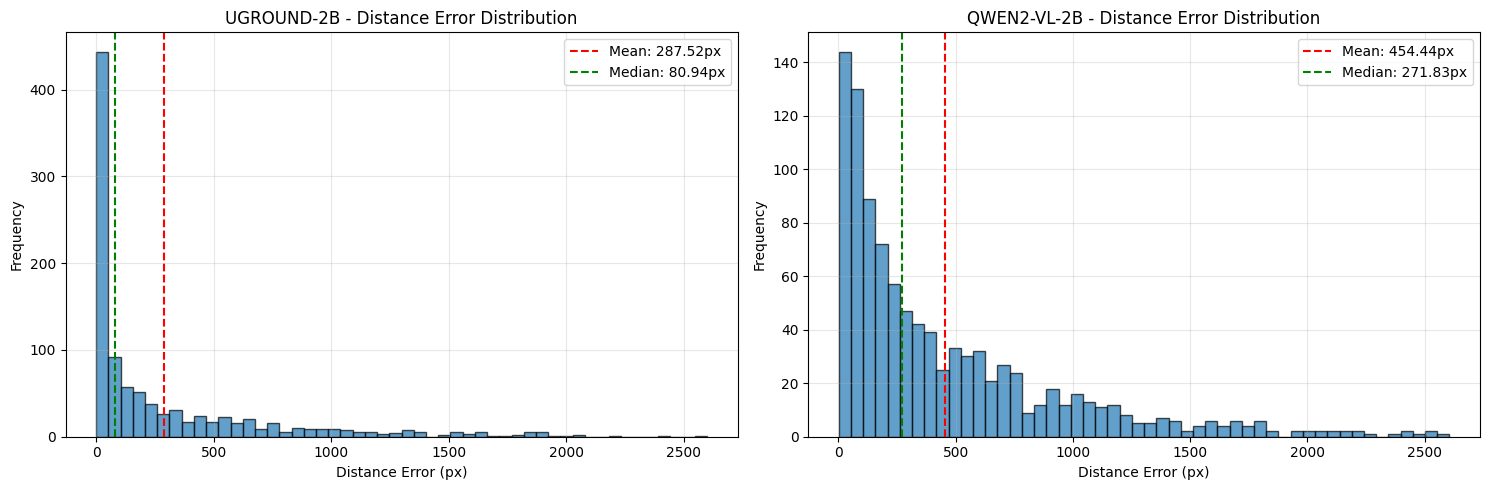

In [36]:
# Plot distance distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, model_key in enumerate(MODEL_CONFIGS.keys()):
    distances = [r["distance"] for r in results[model_key] 
                 if r.get("distance") != float('inf')]
    
    if distances:
        axes[idx].hist(distances, bins=50, alpha=0.7, edgecolor='black')
        axes[idx].axvline(np.mean(distances), color='red', linestyle='--', 
                         label=f'Mean: {np.mean(distances):.2f}px')
        axes[idx].axvline(np.median(distances), color='green', linestyle='--', 
                         label=f'Median: {np.median(distances):.2f}px')
        axes[idx].set_xlabel('Distance Error (px)')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{model_key.upper()} - Distance Error Distribution')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, 'No valid predictions', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{model_key.upper()} - No Data')

plt.tight_layout()
plt.show()


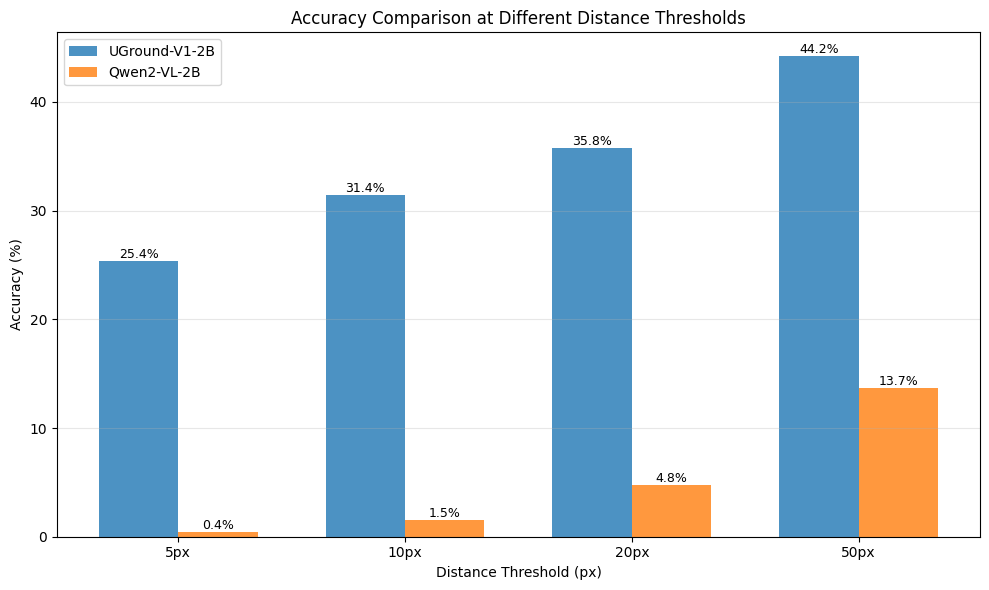

In [39]:
# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))

thresholds = [5, 10, 20, 50]
x = np.arange(len(thresholds))
width = 0.35

uground_accs = [metrics["uground-2b"][f"accuracy_{t}px"] for t in thresholds]
qwen_accs = [metrics["qwen2-vl-2b"][f"accuracy_{t}px"] for t in thresholds]

bars1 = ax.bar(x - width/2, uground_accs, width, label='UGround-V1-2B', alpha=0.8)
bars2 = ax.bar(x + width/2, qwen_accs, width, label='Qwen2-VL-2B', alpha=0.8)

ax.set_xlabel('Distance Threshold (px)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison at Different Distance Thresholds')
ax.set_xticks(x)
ax.set_xticklabels([f'{t}px' for t in thresholds])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 8. Sample Predictions


In [41]:
# Show some example predictions
num_examples = min(5, len(eval_dataset))
print(f"\nShowing {num_examples} example predictions:\n")

for idx in range(num_examples):
    sample = eval_dataset[idx]
    images_list = sample.get("images")
    query = sample.get("easyr1_prompt")
    bbox = sample.get("bbox")
    
    if images_list is None or len(images_list) == 0 or query is None or bbox is None:
        continue
    
    image = images_list[0]
    if not isinstance(image, Image.Image):
        if hasattr(image, "convert"):
            image = image.convert("RGB")
        else:
            continue
    
    try:
        gt_x, gt_y = bbox_to_center(bbox)
    except:
        continue
    
    print(f"\n{'='*80}")
    print(f"Example {idx + 1}")
    print(f"{'='*80}")
    print(f"Query: {query}")
    print(f"Bbox: {bbox}")
    print(f"Ground Truth Center: ({gt_x}, {gt_y})")
    
    for model_key in MODEL_CONFIGS.keys():
        # Find the result for this sample index
        result = None
        for r in results[model_key]:
            if r.get("sample_idx") == idx:
                result = r
                break
        
        if result is None:
            print(f"\n{model_key}: No result found")
            continue
            
        if result.get("error"):
            print(f"\n{model_key}: ERROR - {result['raw_response']}")
        else:
            print(f"\n{model_key}:")
            print(f"  Ground Truth: ({result['gt_x']}, {result['gt_y']})")
            print(f"  Predicted: ({result['pred_x']}, {result['pred_y']})")
            print(f"  Distance Error: {result['distance']:.2f} px")
            print(f"  Raw Response: {result['raw_response']}")



Showing 5 example predictions:


Example 1
Query: You are an expert UI element locator. Given a GUI image and a user's element description, provide the coordinates of the specified element as a single (x,y) point. For elements with area, return the center point.

Output the coordinate pair exactly:
(x,y)

<image>
Tap on Located between 'Background' and 'Notifications' options.
Bbox: [72, 183, 322, 232]
Ground Truth Center: (197, 207)

uground-2b:
  Ground Truth: (197, 207)
  Predicted: (190, 164)
  Distance Error: 43.57 px
  Raw Response: (97, 151)

qwen2-vl-2b:
  Ground Truth: (197, 207)
  Predicted: (0, 1)
  Distance Error: 285.04 px
  Raw Response: (0, 1)

Example 2
Query: You are an expert UI element locator. Given a GUI image and a user's element description, provide the coordinates of the specified element as a single (x,y) point. For elements with area, return the center point.

Output the coordinate pair exactly:
(x,y)

<image>
I will give textual descriptions of a certain ele